In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import networkx as nx
import nxviz as nv

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



/Users/christianwarburg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/christianwarburg/anaconda3/lib/python3.11/site-packages/nxviz/__init__.py:33: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
pd.options.mode.chained_assignment = None

chunk = pd.read_csv('emails.csv', chunksize=5000)
data = next(chunk)

data.info()

len(data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     5000 non-null   object
 1   message  5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


5000

In [3]:
def get_text(Series, row_num_slicer):
    """returns a Series with text sliced from a list split from each message. Row_num_slicer
    tells function where to slice split text to find only the body of the message."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        del message_words[:row_num_slicer]
        result.iloc[row] = message_words
    return result

def get_row(Series, row_num):
    """returns a single row split out from each message. Row_num is the index of the specific
    row that you want the function to return."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        message_words = message_words[row_num]
        result.iloc[row] = message_words
    return result

def get_address(df, Series, num_cols=1):
    """returns a specified email address from each row in a Series"""
    address = re.compile('[\w\.-]+@[\w\.-]+\.\w+')
    addresses = []
    result1 = pd.Series(index=df.index)
    result2 = pd.Series(index=df.index)
    result3 = pd.Series(index=df.index)
    for i in range(len(df)):
        for message in Series:
            correspondents = re.findall(address, message)
            addresses.append(correspondents)
            result1[i] = addresses[i][0]
        if num_cols >= 2:
            if len(addresses[i]) >= 3:
                result2[i] = addresses[i][1]
                if num_cols == 3:
                    if len(addresses[i]) >= 4:
                        result3[i] = addresses[i][2]
    return result1, result2, result3

def standard_format(df, Series, string, slicer):
    """Drops rows containing messages without some specified value in the expected locations. 
    Returns original dataframe without these values. Don't forget to reindex after doing this!!!"""
    rows = []
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        if string not in message_words[slicer]:
            rows.append(row)
    df = df.drop(df.index[rows])
    return df


In [4]:
x = len(data.index)
headers = ['Message-ID: ', 'Date: ', 'From: ', 'To: ', 'Subject: ']
for i, v in enumerate(headers):
    data = standard_format(data, data.message, v, i)
data = data.reset_index()
print("Got rid of {} useless emails! That's {}% of the total number of messages in this dataset.".format(x - len(data.index), np.round(((x - len(data.index)) / x) * 100, decimals=2)))

Got rid of 268 useless emails! That's 5.36% of the total number of messages in this dataset.


In [5]:

data['text'] = get_text(data.message, 15)
data['date'] = get_row(data.message, 1)
data['senders'] = get_row(data.message, 2)
data['recipients'] = get_row(data.message, 3)
data['subject'] = get_row(data.message, 4)

data.date = data.date.str.replace('Date: ', '')
data.date = pd.to_datetime(data.date)

data.subject = data.subject.str.replace('Subject: ', '')

data['recipient1'], data['recipient2'], data['recipient3'] = get_address(data, data.recipients, num_cols=3)
data['sender'], x, y = get_address(data, data.senders)

# Count emails per sender and filter for active senders
data = data[data['sender'].str.contains('@enron', na=False)]
data = data[data['recipient1'].str.contains('@enron', na=False)]
sender_counts = data['sender'].value_counts()
active_senders = sender_counts[sender_counts > 50].index
data = data[data['sender'].isin(active_senders)]

# Select and reorder columns
data = data[['date', 'sender', 'recipient1', 'recipient2', 'recipient3', 'subject', 'text']]

# Create the graph from filtered data
G = nx.from_pandas_edgelist(data, 'sender', 'recipient1', edge_attr=['date', 'subject'])


/var/folders/sk/hthlcg_s6vbg6k9jgx90gph00000gn/T/ipykernel_81176/551219085.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['', 'Here is our forecast', '', ' ']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.iloc[row] = message_words
/var/folders/sk/hthlcg_s6vbg6k9jgx90gph00000gn/T/ipykernel_81176/551219085.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.iloc[row] = message_words
/var/folders/sk/hthlcg_s6vbg6k9jgx90gph00000gn/T/ipykernel_81176/551219085.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'From: phillip.allen@enron.com' has d

['phillip.allen@enron.com', 'tim.belden@enron.com', 'john.lavorato@enron.com', 'leah.arsdall@enron.com', 'randall.gay@enron.com', 'greg.piper@enron.com', 'david.l.johnson@enron.com', 'joyce.teixeira@enron.com', 'mark.scott@enron.com', 'zimam@enron.com', 'keith.holst@enron.com', 'david.delainey@enron.com', 'paula.harris@enron.com', 'ina.rangel@enron.com', 'tim.heizenrader@enron.com', 'jeffrey.hodge@enron.com', 'kholst@enron.com', 'cindy.cicchetti@enron.com', 'christopher.calger@enron.com', 'kathy.moore@enron.com', 'james.steffes@enron.com', 'paul.lucci@enron.com', 'tori.kuykendall@enron.com', 'frank.hayden@enron.com', 'mike.grigsby@enron.com', 'cooper.richey@enron.com', 'kolinge@enron.com', 'cindy.long@enron.com', 'alan.comnes@enron.com', 'suzanne.nicholie@enron.com', 'colleen.sullivan@enron.com', 'brad.mcsherry@enron.com', 'bruce.ferrell@enron.com', 'stephanie.sever@enron.com', 'stephen.harrington@enron.com', 'sunil.dalal@enron.com', 'barry.steinhart@enron.com', 'matt.smith@enron.com',

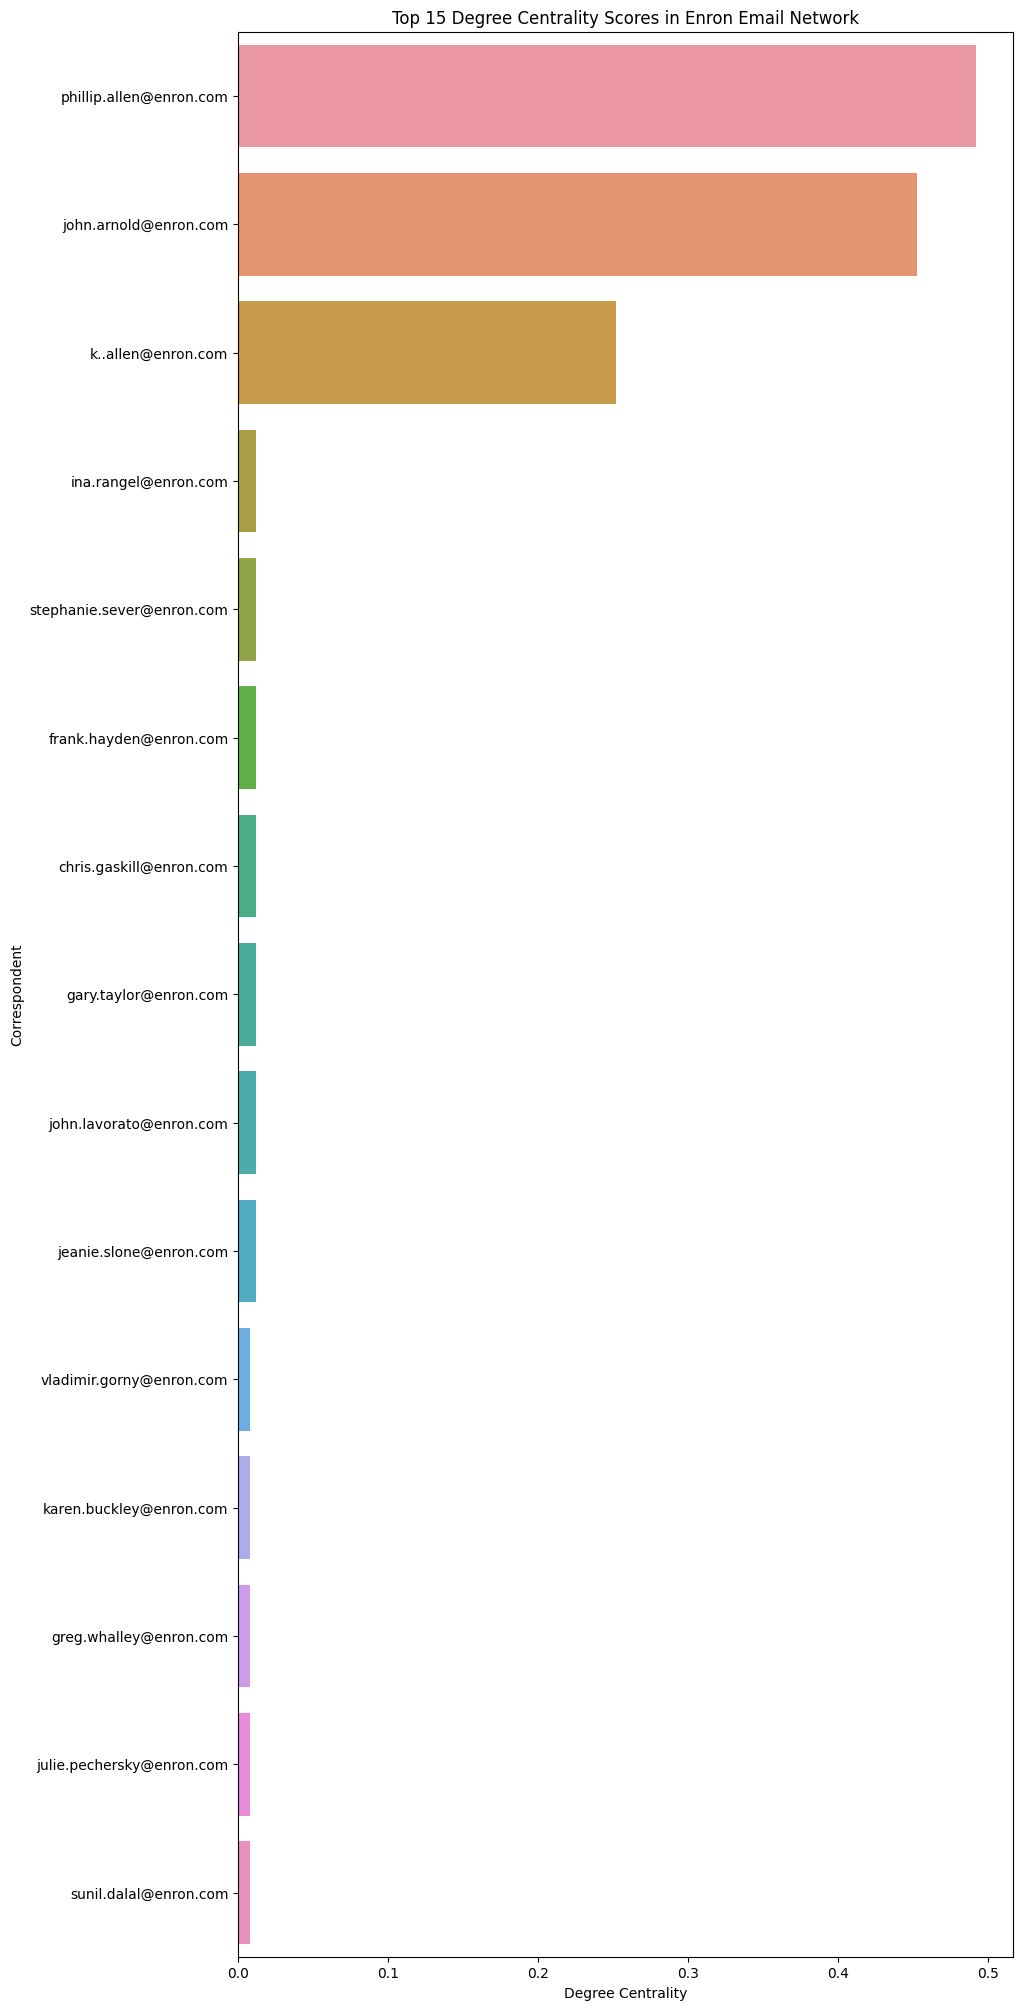

In [8]:
G = nx.from_pandas_edgelist(data, 'sender', 'recipient1', edge_attr=['date', 'subject'])

cent = nx.degree_centrality(G)
name = []
centrality = []

for key, value in cent.items():
    name.append(key)
    centrality.append(value)

cent = pd.DataFrame()    
cent['name'] = name
cent['centrality'] = centrality
cent = cent.sort_values(by='centrality', ascending=False)

plt.figure(figsize=(10, 25))
_ = sns.barplot(x='centrality', y='name', data=cent[:15], orient='h')
_ = plt.xlabel('Degree Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Degree Centrality Scores in Enron Email Network')
print(G.nodes())
print(len(G.nodes()))

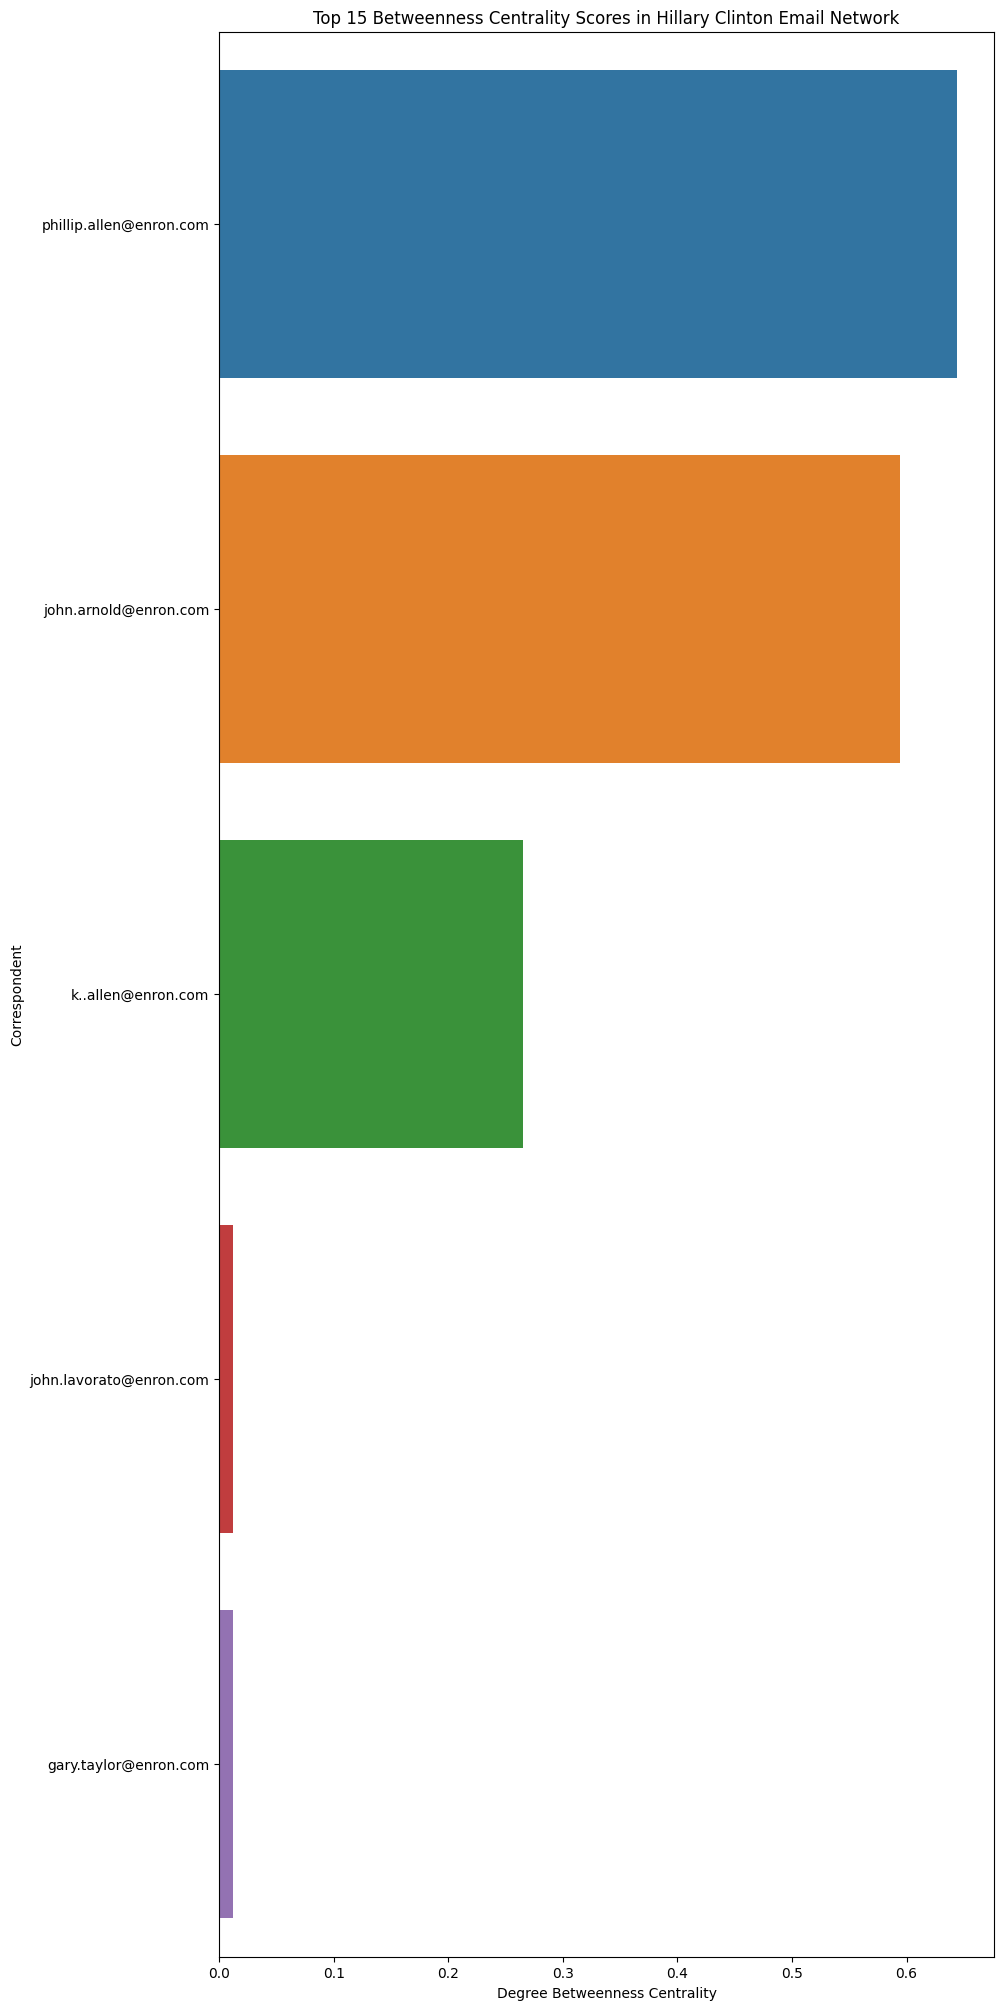

In [9]:
between = nx.betweenness_centrality(G)
name = []
betweenness = []

for key, value in between.items():
    name.append(key)
    betweenness.append(value)

bet = pd.DataFrame()
bet['name'] = name
bet['betweenness'] = betweenness
bet = bet.sort_values(by='betweenness', ascending=False)


plt.figure(figsize=(10, 25))
_ = sns.barplot(x='betweenness', y='name', data=bet[:5], orient='h')
_ = plt.xlabel('Degree Betweenness Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Betweenness Centrality Scores in Hillary Clinton Email Network')
plt.show()